# Identifying duplicate ROIs imaged in successive planes

### Note: This notebook was used for testing. The "production-level" duplicate checks are now done in `data_loading/duplicate_rois.py`

In [29]:
import sys
if "../.." not in sys.path: sys.path.insert(0, "../..")
if ".." not in sys.path: sys.path.insert(0, "..")
import random

import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm
import scipy

from experiment.v1dd_client import V1DDClient
from experiment.v1dd_ophys_session import V1DDOPhysSession

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
base_folder = "/Users/chase/Desktop/test_v1dd_data"
client = V1DDClient(base_folder)

## This is used to sanity check duplicates

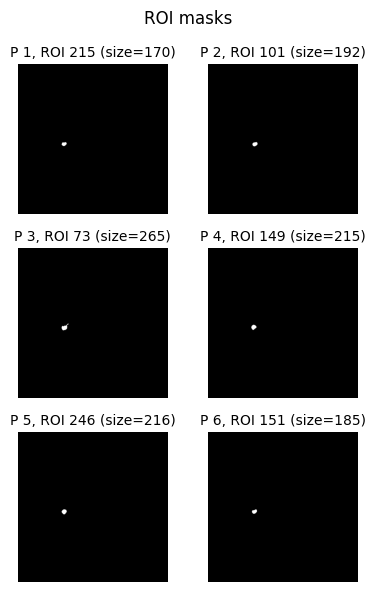

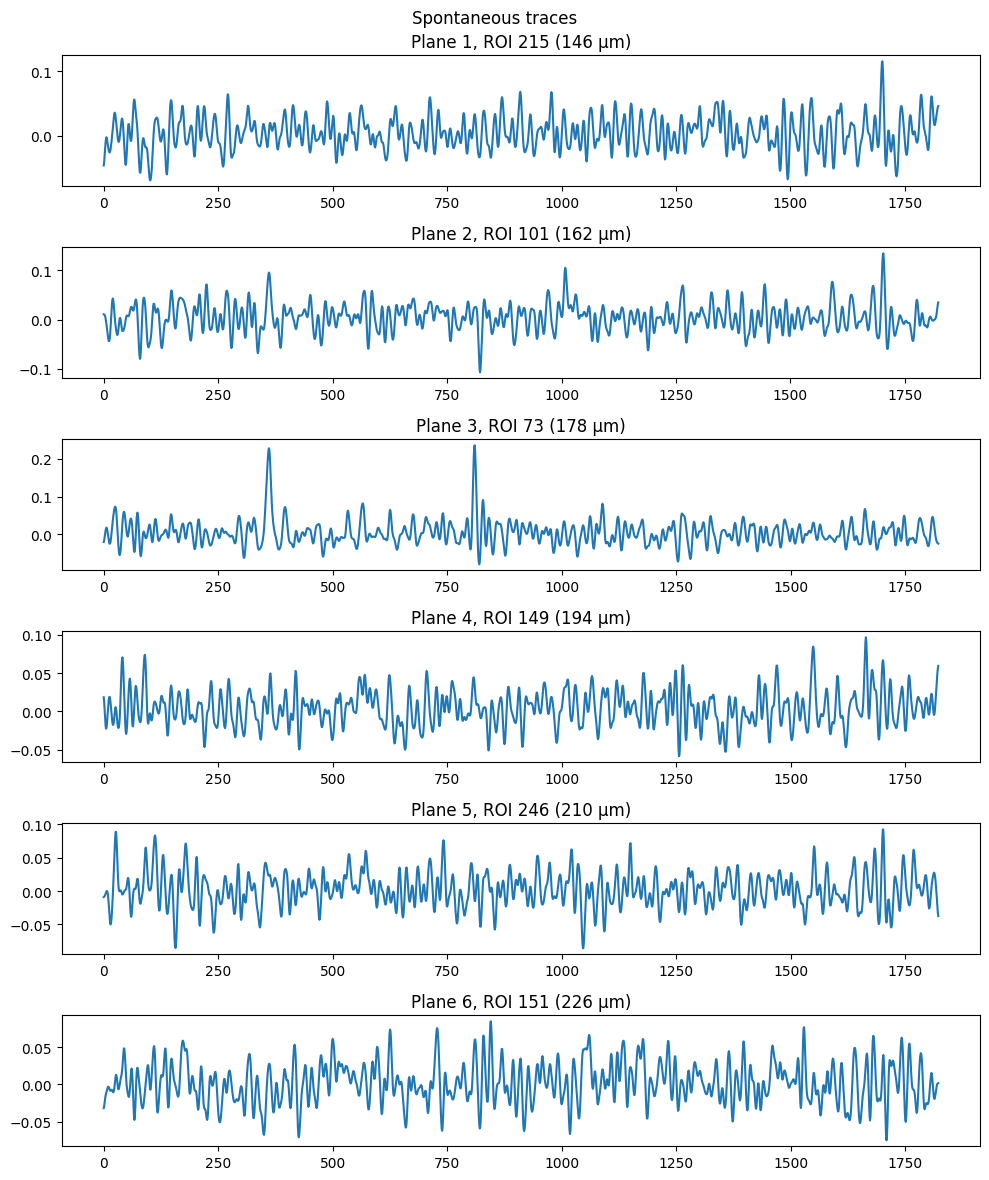

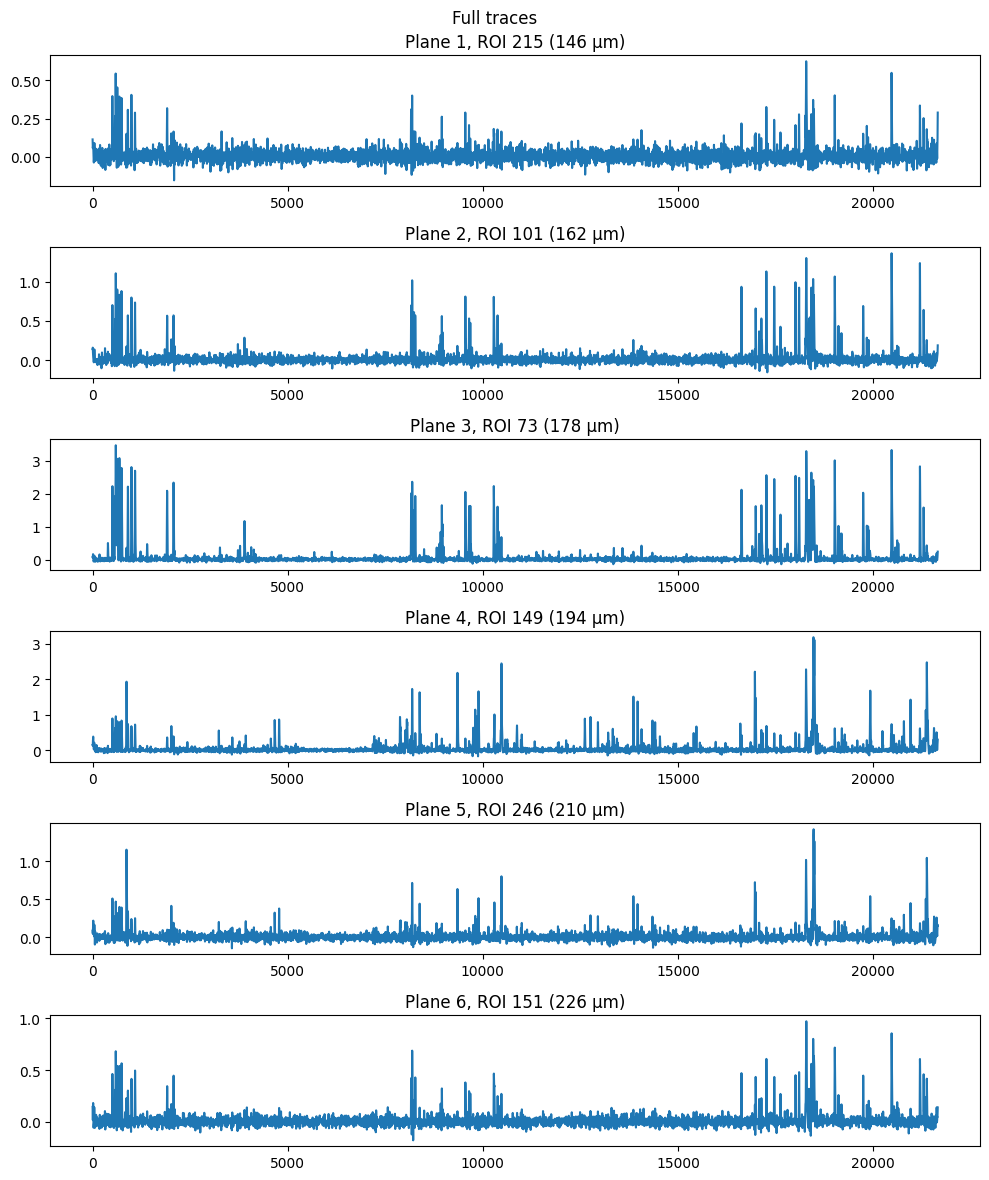

In [86]:
def check_duplicates(duplicates_str):
    planes_and_rois = []

    for roi_tag in duplicates_str.split(", "):
        roi_tag = roi_tag.split("_")
        planes_and_rois.append((int(roi_tag[2]), int(roi_tag[3])))
    
    planes_and_rois.sort()

    # Assume they are all from the same session
    session_id = duplicates_str[:10] # e.g., M409828_13
    session = client.load_ophys_session(session_id=session_id)
    
    # Plot ROI masks
    nrows = 4 if len(planes_and_rois) > 6 else 3
    fig, axs = plt.subplots(figsize=(4, 2*nrows), nrows=nrows, ncols=2)
    fig.suptitle("ROI masks")
    for i, ax in enumerate(axs.flatten()):
        ax.axis("off")
        if i < len(planes_and_rois):
            plane, roi = planes_and_rois[i]
            mask = session.get_roi_image_mask(plane, roi)
            ax.set_title(f"P {plane}, ROI {roi} (size={mask.sum()})", fontsize=10)
            ax.imshow(mask, cmap="gray")
    fig.tight_layout()

    # Plot spontaneous traces
    fig, axs = plt.subplots(figsize=(10, 2*len(planes_and_rois)), nrows=len(planes_and_rois))
    fig.suptitle("Spontaneous traces")
    for (plane, roi), ax in zip(planes_and_rois, axs):
        depth = session.get_plane_depth(plane)
        ax.set_title(f"Plane {plane}, ROI {roi} ({depth} µm)")
        ax.plot(scipy.ndimage.gaussian_filter1d(session.get_spont_traces(plane=plane, trace_type="dff")[roi], sigma=3))
    fig.tight_layout()

    # Plot all traces
    fig, axs = plt.subplots(figsize=(10, 2*len(planes_and_rois)), nrows=len(planes_and_rois))
    fig.suptitle("Full traces")
    for (plane, roi), ax in zip(planes_and_rois, axs):
        depth = session.get_plane_depth(plane)
        ax.set_title(f"Plane {plane}, ROI {roi} ({depth} µm)")
        ax.plot(scipy.ndimage.gaussian_filter1d(session.get_traces(plane=plane, roi=roi, trace_type="dff")[0], sigma=3))
    fig.tight_layout()

# check_duplicates("M409828_14_1_87, M409828_14_2_92, M409828_14_3_31, M409828_14_1_320, M409828_14_4_10, M409828_14_5_29, M409828_14_6_17")
# check_duplicates("M409828_12_1_66, M409828_12_2_19, M409828_12_3_8, M409828_12_4_2, M409828_12_5_42, M409828_12_6_8")
# check_duplicates("M409828_12_1_126, M409828_12_2_32, M409828_12_3_25, M409828_12_4_36, M409828_12_5_45, M409828_12_6_49")
# check_duplicates("M409828_13_1_204, M409828_13_2_79, M409828_13_3_45, M409828_13_4_72, M409828_13_5_276, M409828_13_6_49")
# check_duplicates("M409828_12_1_153, M409828_12_2_44, M409828_12_3_28, M409828_12_4_21, M409828_12_5_158, M409828_12_6_143") # not clear in spontaneous
check_duplicates("M409828_12_1_215, M409828_12_2_101, M409828_12_3_73, M409828_12_4_149, M409828_12_5_246, M409828_12_6_151")

## The actual code

In [31]:
MOUSE = 409828
column, volume = 1, 3
sess = client.load_ophys_session(mouse=409828, column=column, volume=volume)

### Automated method

In [52]:
from data_loading.duplicate_rois import get_duplicate_roi_pairs_in_session, get_unique_duplicate_rois

dup_pairs = get_duplicate_roi_pairs_in_session(sess)
dups = get_unique_duplicate_rois(dup_pairs)

Correlating ROI traces...:   0%|          | 0/5 [00:00<?, ?it/s]

In [53]:
len(dup_pairs), len(dups)

(808, 508)

### Manual method

In [4]:
# Compute ROI centroids for valid ROIs in all planes
# This is used as a way of filtering ROI pairs to check
# (ROIs that are far apart won't have their traces compared)
roi_centroids = {
    plane: {
        roi: np.mean(np.where(sess.get_roi_image_mask(plane=plane, roi=roi)), axis=1)
        for roi in np.where(sess.is_roi_valid(plane=plane))[0]
    }
    for plane in sess.get_planes()
}

In [5]:
MAX_PIXELS_BETWEEN_CENTROIDS = 50 # Used to filter ROIs before comparing traces so not every ROI pair is compared
TRACE_TYPE = "dff"
TRACE_STIMULUS_TYPE = "all" # The full trace from the experiment
# TRACE_STIMULUS_TYPE = "spontaneous" # Only trace during spontaneous stimulus (300 seconds)
dt = 0.165 # sampling distance (1/Hz); approx. 6 Hz
GAUSSIAN_FILTER_SIGMA = 3

planes = sess.get_planes()
roi_comparisons = {} # (plane1, roi1, plane2, roi2): { corr_orig: _, corr_smoothed: _, centroid_dist: _, mask_similarity: _ }

for plane_i in tqdm(range(len(planes) - 1), desc="Correlating ROI traces..."):
    plane_1, plane_2 = planes[plane_i], planes[plane_i+1]

    if TRACE_STIMULUS_TYPE == "all":
        all_traces_1, _ = sess.get_traces(plane=plane_1, trace_type=TRACE_TYPE)
        all_traces_2, _ = sess.get_traces(plane=plane_2, trace_type=TRACE_TYPE)
    elif TRACE_STIMULUS_TYPE == "spontaneous":
        all_traces_1 = sess.get_spont_traces(plane=plane_1, trace_type=TRACE_TYPE)
        all_traces_2 = sess.get_spont_traces(plane=plane_2, trace_type=TRACE_TYPE)
    
    # Ensure traces have same length (dim 1)
    trace_len = min(all_traces_1.shape[1], all_traces_2.shape[1])
    all_traces_1 = all_traces_1[:, :trace_len]
    all_traces_2 = all_traces_2[:, :trace_len]

    # dt = np.mean(np.diff(timestamps_1)) # should be within epsilon across planes
    # fftfreq = fft.rfftfreq(n=trace_len, d=dt)
    # fftfreq_clean_mask = fftfreq < 0.5 # Only low frequencies
    # TODO: Tune this paramenter    ^

    for roi_1, centroid_1 in roi_centroids[plane_1].items():
        trace_1 = all_traces_1[roi_1]
        roi_mask_1 = sess.get_roi_image_mask(plane=plane_1, roi=roi_1)

        # FFT
        # fft_1 = fft.rfft(trace_1)
        # trace_1_clean = fft.irfft(fft_1 * fftfreq_clean_mask)
        trace_1_clean = scipy.ndimage.gaussian_filter1d(trace_1, sigma=GAUSSIAN_FILTER_SIGMA)

        for roi_2, centroid_2 in roi_centroids[plane_2].items():
            # If they are far apart, don't bother comparing
            centroid_dist = np.linalg.norm(centroid_1 - centroid_2)
            if centroid_dist > MAX_PIXELS_BETWEEN_CENTROIDS:
                continue
            
            trace_2 = all_traces_2[roi_2]
            roi_mask_2 = sess.get_roi_image_mask(plane=plane_2, roi=roi_2)
            mask_similarity = np.sum(roi_mask_1 & roi_mask_2) / np.sum(roi_mask_1 | roi_mask_2) # Jaccard similarity = intersection / union
            corr_coef = np.corrcoef(trace_1, trace_2)[0, 1]

            # fft_2 = fft.rfft(trace_2)
            # trace_2_clean = fft.irfft(fft_2 * fftfreq_clean_mask)
            trace_2_clean = scipy.ndimage.gaussian_filter1d(trace_2, sigma=GAUSSIAN_FILTER_SIGMA)
            corr_coef_clean = np.corrcoef(trace_1_clean, trace_2_clean)[0, 1]

            roi_comparisons[(plane_1, roi_1, plane_2, roi_2)] = {
                "corr_orig": corr_coef,
                "corr_smoothed": corr_coef_clean,
                "centroid_dist": centroid_dist,
                "mask_similarity": mask_similarity
            }


            # if corr_coef_clean > 0.9:
            #     plt.figure()
            #     plt.plot(trace_1_clean[t])
            #     plt.plot(trace_2_clean[t])

    # break # Only check ROIs in plane 1 and 2

Correlating ROI traces...:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
def comparison_scatter(x, y, figsize=(7, 7)):
    plt.figure(figsize=figsize)

    for plane_i in range(len(planes) - 1):
        plane_1, plane_2 = planes[plane_i], planes[plane_i+1]
        X = []
        Y = []

        for key, val in roi_comparisons.items():
            if key[0] == plane_1:
                X.append(val[x])
                Y.append(val[y])

        plt.scatter(X, Y, s=10, alpha=0.5, label=f"Planes {plane_1} & {plane_2}")

    plt.legend()
    plt.xlabel(f"{x}", fontsize=12)
    plt.ylabel(f"{y}", fontsize=12)
    plt.title("$\Delta$F/F trace correlations in Column 1, Volume 3")

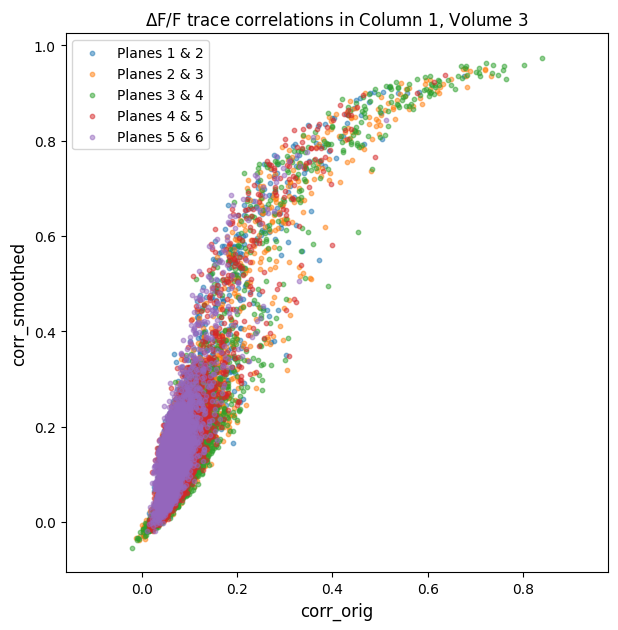

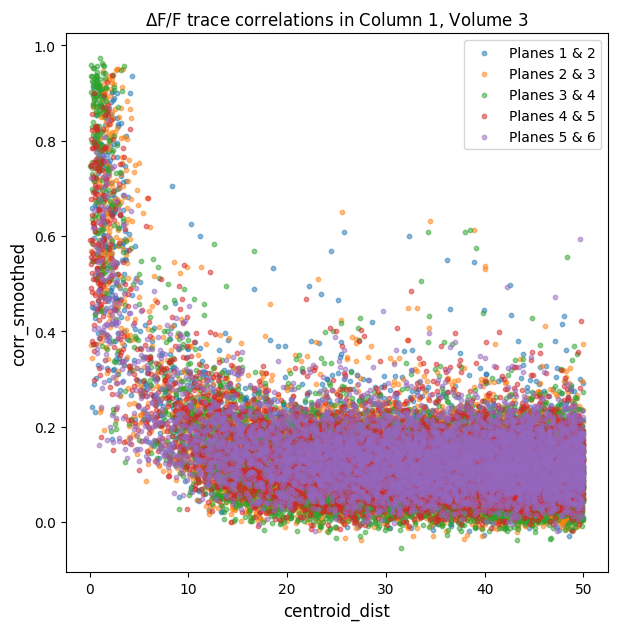

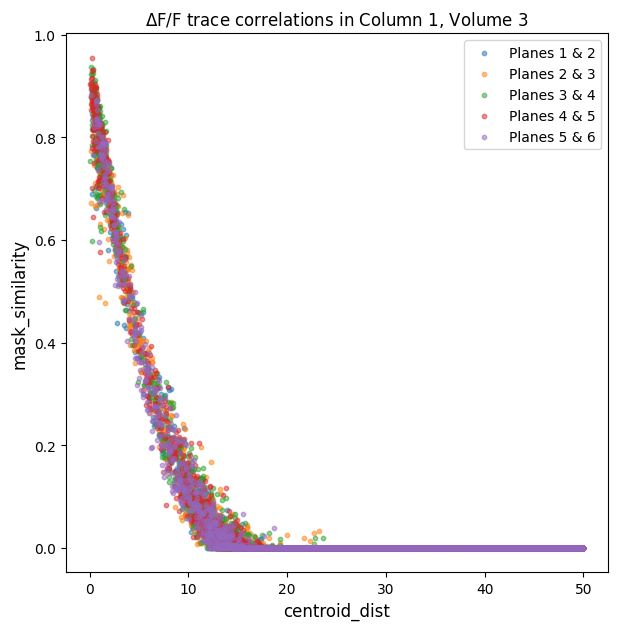

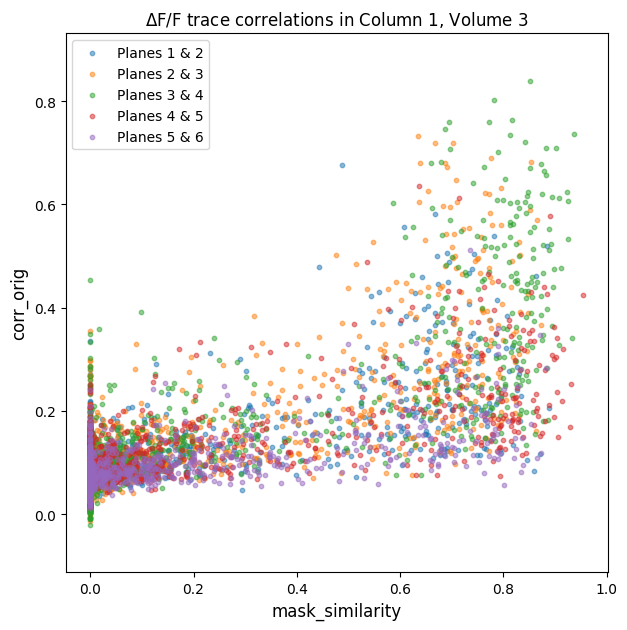

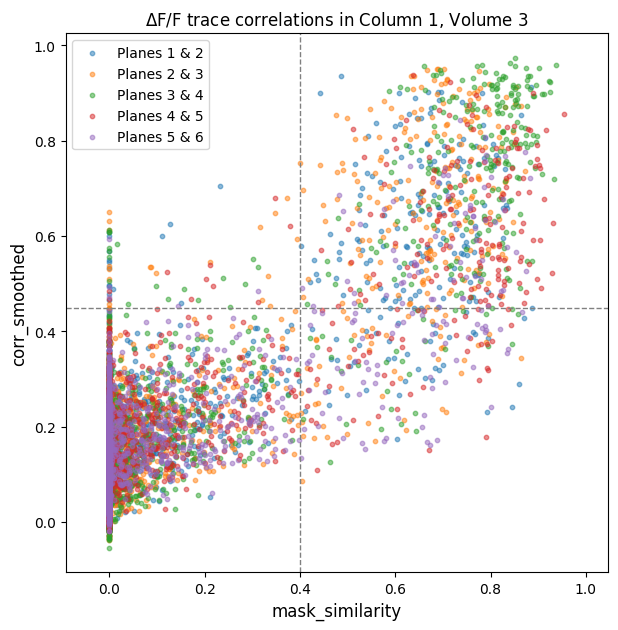

In [8]:
comparison_scatter(x="corr_orig", y="corr_smoothed")
plt.axis("equal")

comparison_scatter(x="centroid_dist", y="corr_smoothed")

comparison_scatter(x="centroid_dist", y="mask_similarity")

comparison_scatter(x="mask_similarity", y="corr_orig")
plt.axis("equal")

comparison_scatter(x="mask_similarity", y="corr_smoothed")
plt.axis("equal")
plt.axvline(x=0.4, color="gray", linestyle="dashed", linewidth=1)
plt.axhline(y=0.45, color="gray", linestyle="dashed", linewidth=1)

In [10]:
# How many ROIs are duplicates?
duplicate_bounds = { # key: (lower_bound, upper_bound)
    "mask_similarity": (0.4, None),
    "corr_smoothed": (0.45, None)
}

duplicates = [] # (plane_1, roi_1, plane_2, roi_2)

for plane_i in range(len(planes) - 1):
    plane_1, plane_2 = planes[plane_i], planes[plane_i+1]
    n_tot = 0
    n_dup = 0

    for key, data in roi_comparisons.items():
        if key[0] == plane_1: # In plane
            n_tot += 1

            # Check if this is a duplicate (i.e., doesn't violate any lower or upper bounds)
            is_duplicate = True
            for bound_key, (lb, ub) in duplicate_bounds.items():
                if (lb is not None and data[bound_key] < lb) or (ub is not None and data[bound_key] > ub):
                    is_duplicate = False
                    break

            if is_duplicate:
                n_dup += 1
                duplicates.append(key)

    print(f"Planes {plane_1} & {plane_2} duplicates: {n_dup} / {n_tot} ({n_dup/n_tot*100:.1f}%)")

print(f"{len(duplicates)} total duplicates across {len(planes)} planes")

Planes 1 & 2 duplicates: 154 / 5933 (2.6%)
Planes 2 & 3 duplicates: 204 / 6846 (3.0%)
Planes 3 & 4 duplicates: 231 / 6922 (3.3%)
Planes 4 & 5 duplicates: 152 / 6373 (2.4%)
Planes 5 & 6 duplicates: 67 / 5851 (1.1%)
808 total duplicates across 6 planes


In [34]:
# Save duplicates to CSV file
duplicate_metrics_keys = list(roi_comparisons[duplicates[0]].keys()) # ['corr_orig', 'corr_smoothed', 'centroid_dist', 'mask_similarity']
duplicate_df = pd.DataFrame(columns=["mouse", "column", "volume", "plane_1", "roi_1", "plane_2", "roi_2"] + duplicate_metrics_keys)

for key in duplicates:
    comparison_metrics = roi_comparisons[key]
    metrics_vals = tuple(comparison_metrics[k] for k in duplicate_metrics_keys)
    row = (MOUSE, column, volume) + key + metrics_vals
    duplicate_df.loc[len(duplicate_df)] = row

duplicate_df = duplicate_df.convert_dtypes()
print(f"There are {len(duplicate_df)} duplicates across {len(duplicate_df.volume.unique())} volumes")

duplicate_df

There are 736 duplicates across 1 volumes


,mouse,column,volume,plane_1,roi_1,plane_2,roi_2,corr_orig,corr_smoothed,centroid_dist,mask_similarity
0,409828,1,3,1,0,2,214,0.276933,0.57707,2.435491,0.630081
1,409828,1,3,1,1,2,35,0.429438,0.803062,2.164732,0.629442
2,409828,1,3,1,3,2,65,0.538057,0.862362,1.209965,0.781726
3,409828,1,3,1,6,2,66,0.501065,0.810849,1.645811,0.672131
4,409828,1,3,1,8,2,70,0.675569,0.913216,4.285382,0.486667
...,...,...,...,...,...,...,...,...,...,...,...
731,409828,1,3,5,421,6,183,0.155878,0.454172,1.24056,0.779661
732,409828,1,3,5,430,6,277,0.325483,0.714209,1.366809,0.7897
733,409828,1,3,5,449,6,181,0.178903,0.482605,2.33473,0.644444
734,409828,1,3,5,501,6,240,0.175719,0.498894,0.74202,0.853261


In [35]:
duplicate_df.to_csv(f"/Users/chase/Desktop/duplicate_rois_M{MOUSE}_C{column}_V{volume}.csv", index=False)

## Visualize a randomly-chosen duplicate ROI pairing
Used to estimate how well the algorithm works in practice.

(2, 488, 3, 196) {'corr_orig': 0.21998833604241608, 'corr_smoothed': 0.5024711296033376, 'centroid_dist': 1.1090552262490838, 'mask_similarity': 0.7941176470588235}
0.8144329896907216


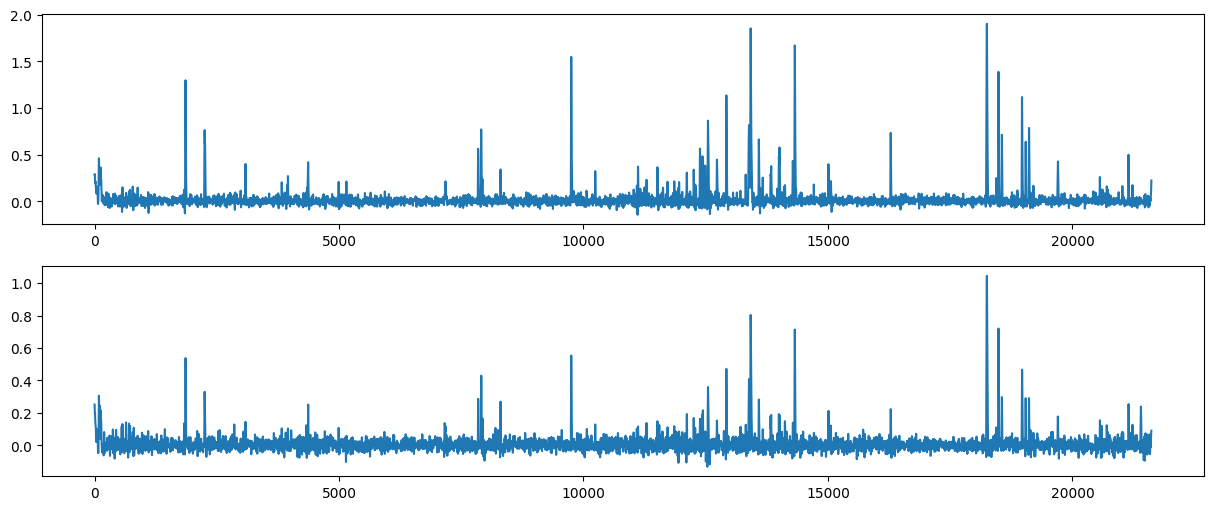

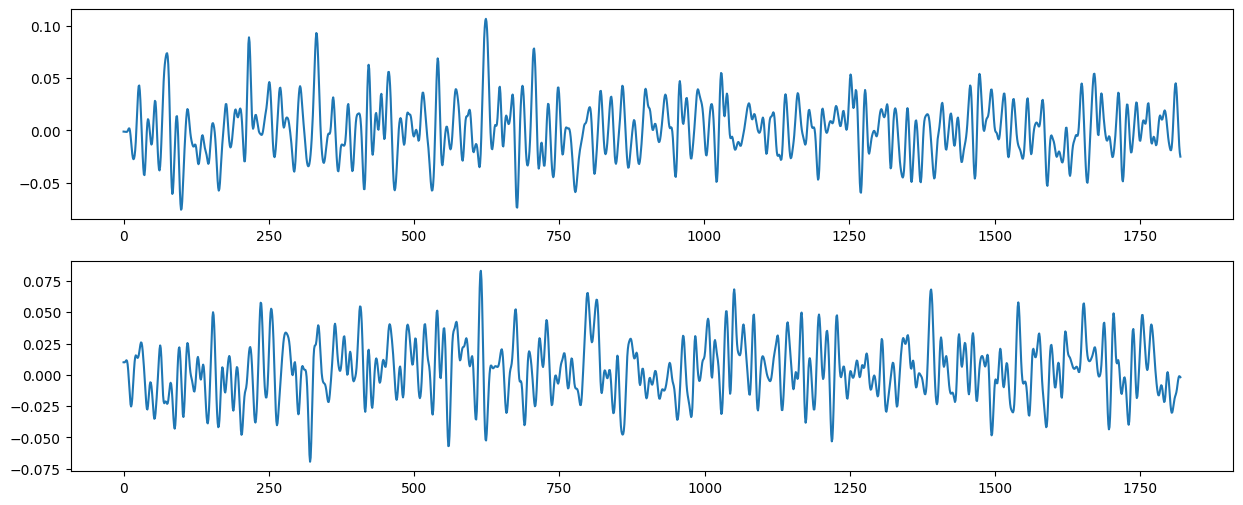

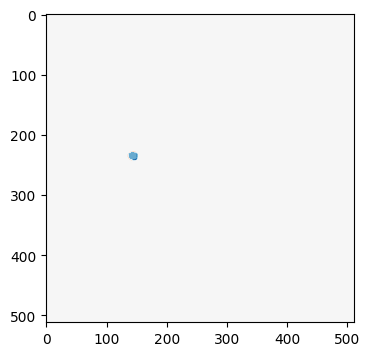

In [33]:
# plane_1, roi_1, plane_2, roi_2 = 3, 85, 4, 45
# plane_1, roi_1, plane_2, roi_2 = 2, 112, 3, 171
# plane_1, roi_1, plane_2, roi_2 = 2, 238, 3, 401
# plane_1, roi_1, plane_2, roi_2 = 3, 25, 4, 91
# plane_1, roi_1, plane_2, roi_2 = 3, 85, 4, 45
key = random.choice(duplicates)
plane_1, roi_1, plane_2, roi_2 = key
print(key, roi_comparisons[key])

plane_1, roi_1, plane_2, roi_2 = 3, 294, 4, 325

fig, axs = plt.subplots(figsize=(15, 6), nrows=2)
axs[0].plot(scipy.ndimage.gaussian_filter1d(sess.get_traces(plane=plane_1, roi=roi_1, trace_type="dff")[0], sigma=GAUSSIAN_FILTER_SIGMA))
axs[1].plot(scipy.ndimage.gaussian_filter1d(sess.get_traces(plane=plane_2, roi=roi_2, trace_type="dff")[0], sigma=GAUSSIAN_FILTER_SIGMA))
# axs[0].plot(sess.get_traces(plane=plane_1, roi=roi_1, trace_type="dff")[0])
# axs[1].plot(sess.get_traces(plane=plane_2, roi=roi_2, trace_type="dff")[0])

# fig, axs = plt.subplots(figsize=(15, 6), nrows=2)
# axs[0].plot(sess.get_traces(plane=plane_1, roi=roi_1, trace_type="events")[0])
# axs[1].plot(sess.get_traces(plane=plane_2, roi=roi_2, trace_type="events")[0])

fig, axs = plt.subplots(figsize=(15, 6), nrows=2)
axs[0].plot(scipy.ndimage.gaussian_filter1d(sess.get_spont_traces(plane=plane_1, trace_type="dff")[roi_1], sigma=GAUSSIAN_FILTER_SIGMA))
axs[1].plot(scipy.ndimage.gaussian_filter1d(sess.get_spont_traces(plane=plane_2, trace_type="dff")[roi_2], sigma=GAUSSIAN_FILTER_SIGMA))
# axs[0].plot(sess.get_spont_traces(plane=plane_1, trace_type="dff")[roi_1])
# axs[1].plot(sess.get_spont_traces(plane=plane_2, trace_type="dff")[roi_2])

plt.figure(figsize=(4, 4))
mask_1 = sess.get_roi_image_mask(plane=plane_1, roi=roi_1)
mask_2 = sess.get_roi_image_mask(plane=plane_2, roi=roi_2)
intersection = np.sum(mask_1 & mask_2)
union = np.sum(mask_1 | mask_2)
print(intersection/union)
plt.imshow(mask_1.astype(int)*2 - mask_2.astype(int), cmap="RdBu", vmin=-2, vmax=2)

## Check smoothing parameters

dt_1 = 0.16518458061531344, dt_2=0.1651846074485311


Text(0, 0.5, 'Power')

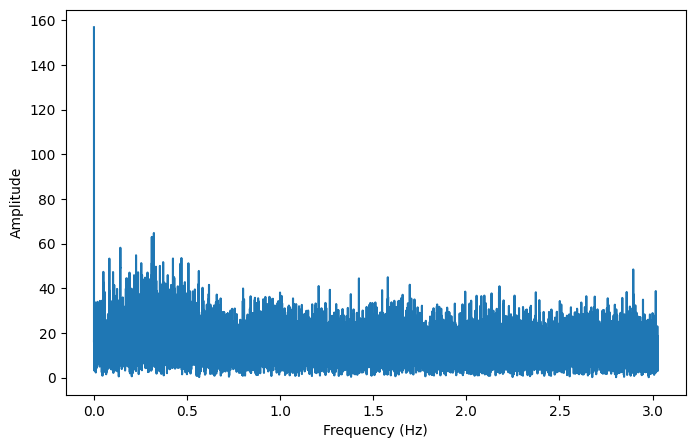

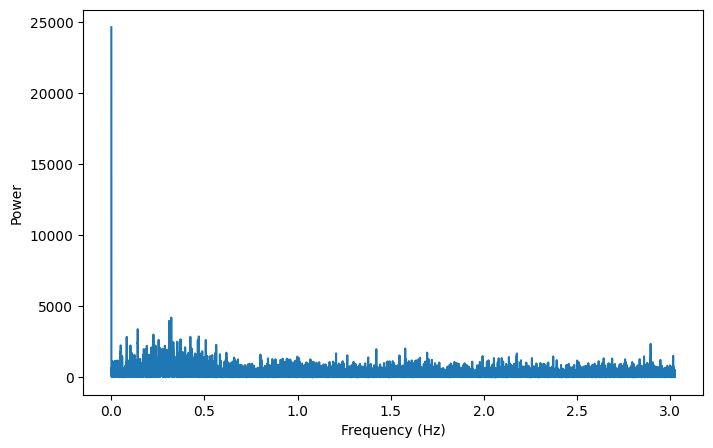

In [18]:
plane_1, roi_1, plane_2, roi_2 = 1, 111, 2, 380 # These are duplicates

roi_1 = random.choice(np.where(sess.is_roi_valid(plane=plane_1))[0])

trace_1, ts_1 = sess.get_traces(plane=plane_1, roi=roi_1, trace_type=TRACE_TYPE)
trace_2, ts_2 = sess.get_traces(plane=plane_2, roi=roi_2, trace_type=TRACE_TYPE)
dt_1 = np.mean(np.diff(ts_1))
dt_2 = np.mean(np.diff(ts_2))
print(f"dt_1 = {dt_1}, dt_2={dt_2}")

fft_1 = fft.rfft(trace_1)
amp_1 = np.abs(fft_1)
power_1 = np.square(amp_1)
freq_1 = fft.rfftfreq(n=len(trace_1), d=dt_1)

plt.figure(figsize=(8, 5))
plt.plot(freq_1, amp_1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")

plt.figure(figsize=(8, 5))
plt.plot(freq_1, power_1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")

In [67]:
trace_1_filtered = scipy.ndimage.gaussian_filter1d(trace_1, sigma=3)
trace_2_filtered = scipy.ndimage.gaussian_filter1d(trace_2, sigma=3)

print(np.corrcoef(trace_1, trace_2)[0, 1])
print(np.corrcoef(trace_1_filtered, trace_2_filtered)[0, 1])
np.corrcoef(trace_1, trace_2)

# fft_1 = fft.rfft(trace_1)
# amp_1 = np.abs(fft_1)
# power_1 = np.square(amp_1)
# freq_1 = fft.rfftfreq(n=len(trace_1), d=dt_1)
# # plt.plot(fft.irfft(fft_1 * (amp_1 > 40))[:500])
# # plt.plot(trace_1[:500])

0.0828930384593239
0.21077689008520092


array([[1.        , 0.08289304],
       [0.08289304, 1.        ]])

In [6]:
fft_1_mask = amp_1 > 25 # ???
trace_1_smoothed = fft.irfft(fft_1 * fft_1_mask)
plt.figure(figsize=(12, 5))
plt.plot(trace_1)
plt.plot(trace_1_smoothed)
plt.xlim(0, len(trace_1))

NameError: name 'amp_1' is not defined

# (OLD) Automated checking for duplicate ROIs

In [5]:
# Load metrics
metrics = pd.read_csv("/Users/chase/Desktop/MindScope/Documents/v1dd-chase/dataframes/v1dd_metrics.csv", index_col=0, low_memory=False)
metrics = metrics[metrics.is_valid]
def str_to_int(x):
    try:
        return int(x)
    except:
        return str(x)
metrics["volume"] = metrics.volume.apply(str_to_int)

# Tuning curve fits
from stimulus_analysis import fit_utils
metrics.insert(5, "roi_lookup", metrics.apply(lambda row: f"{row.column}-{row.volume}-{row.plane}-{row.roi}", axis=1))
metrics["ssi_fit"] = fit_utils.compute_dg_fit_ssi_from_metrics(metrics)
metrics["dgw_pref_dir_fit"] = fit_utils.get_dg_pref_dir(metrics, "dgw")
metrics["dgf_pref_dir_fit"] = fit_utils.get_dg_pref_dir(metrics, "dgf")
metrics["dgw_r2_fit"] = fit_utils.get_dg_r2_score(metrics, "dgw")
metrics["dgf_r2_fit"] = fit_utils.get_dg_r2_score(metrics, "dgf")

metrics.head()

,mouse,column,volume,plane,roi,roi_lookup,is_valid,depth,dgf_pref_response,dgf_pref_dir,...,ssi_pref_both,ssi_orth,ffsi_all_dirs,spontaneous_event_mean,spontaneous_event_std,ssi_fit,dgw_pref_dir_fit,dgf_pref_dir_fit,dgw_r2_fit,dgf_r2_fit
M409828_11_1_89,409828,1,1,1,89,1-1-1-89,True,50,0.000943,330.0,...,0.033453,-0.139243,"[0.41905364, 0.61911654, 0.07141414, -0.801465...",0.000287,0.001903,0.173092,351.613700,63.683119,0.317339,0.191516
M409828_11_2_0,409828,1,1,2,0,1-1-2-0,True,66,0.000919,270.0,...,-0.088211,0.064530,"[-0.18358487, 0.04251838, -0.30215508, -0.1352...",0.000346,0.002629,-0.076999,46.319837,71.813432,0.030397,0.143525
M409828_11_2_1,409828,1,1,2,1,1-1-2-1,True,66,0.011217,0.0,...,-0.157938,0.044509,"[-4.483465, -0.13942526, -0.10395071, 1.0, -1....",0.000341,0.002262,-0.357757,20.629574,14.344481,0.992914,0.996841
M409828_11_2_2,409828,1,1,2,2,1-1-2-2,True,66,0.001237,120.0,...,-0.005231,-0.203358,"[-0.3096417, 0.6981869, 0.36546794, 0.25718334...",0.000341,0.002412,0.238414,360.000000,63.556494,0.731243,0.072976
M409828_11_2_4,409828,1,1,2,4,1-1-2-4,True,66,0.001093,240.0,...,-0.278688,-0.394162,"[-1.098053, -0.15058127, -0.28383604, -2.51381...",0.000234,0.001601,-0.131294,349.940152,323.599541,0.611449,0.241362


In [6]:
# Hyperparameters
DG_RESPONSIVENESS_THRESHOLD = 0.5
ROI_MASK_SIMILARITY_THRESHOLD = 0.75
CENTROID_DISTANCE_THRESHOLD = 20
DG_FIT_R2_THRESH = 0.6
MOUSE = 409828
COLUMN = 1

In [7]:
metrics[(metrics.mouse == MOUSE) & (metrics.column == COLUMN)].volume.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 'a', 'b', 'c', 'd', 'e', 'f'],
      dtype=object)

In [8]:
# We are only going to use volumes 1-9
volumes = [1, 2, 3, 4, 5, 6, 7, 8, 9]

In [9]:
# Helper functions
def get_roi_centroid_distances(sess, plane1, plane2):
    roi_pos_1 = np.empty((len(sess.get_rois(plane1)), 2)) # 2 dims for x and y coords
    roi_pos_2 = np.empty((len(sess.get_rois(plane2)), 2))

    for (plane, pos_arr) in ((plane1, roi_pos_1), (plane2, roi_pos_2)):
        for roi in sess.get_rois(plane):
            if sess.is_roi_valid(plane, roi):
                mask = sess.get_roi_image_mask(plane, roi)
                pos_arr[roi, :] = np.mean(np.where(mask), axis=1) # each row is a pixel coordinate in the mask; taking mean of columns
            else:
                pos_arr[roi, :] = np.nan # Invalid roi
    
    centroid_distances = np.linalg.norm(roi_pos_1[:, np.newaxis, :] - roi_pos_2[np.newaxis, :, :], axis=2) # shape (n_rois_1, n_rois_2)
    return centroid_distances

def get_dg_pref_dir(row):
    if row.dgw_frac_responsive_trials >= DG_RESPONSIVENESS_THRESHOLD and row.dgw_r2_fit >= DG_FIT_R2_THRESH:
        return row.dgw_pref_dir_fit
        # return row.dgw_pref_dir
    elif row.dgf_frac_responsive_trials >= DG_RESPONSIVENESS_THRESHOLD and row.dgf_r2_fit >= DG_FIT_R2_THRESH:
        return row.dgf_pref_dir_fit
        # return row.dgf_pref_dir
    else:
        return None

In [24]:
duplicate_df = pd.DataFrame(columns=["mouse", "column", "volume", "plane_1", "roi_1", "plane_2", "roi_2", "roi_mask_similarity", "confidence"])

for volume in tqdm(volumes, desc="Computing duplicate ROIs"):
    metrics_mcv = (metrics.mouse == MOUSE) & (metrics.column == COLUMN) & (metrics.volume == volume)
    
    # Load ophys session (needed to get centroids)
    sess = client.load_ophys_session(mouse=MOUSE, column=COLUMN, volume=volume)
    planes = sess.get_planes()

    for plane_i in range(len(planes) - 1): # all but the last plane
        plane1, plane2 = planes[plane_i:plane_i+2]
        centroid_distances = get_roi_centroid_distances(sess, plane1, plane2)
        
        for roi1, roi2 in zip(*np.where(centroid_distances <= CENTROID_DISTANCE_THRESHOLD)):
            mask1 = sess.get_roi_image_mask(plane1, roi1)
            mask2 = sess.get_roi_image_mask(plane2, roi2)
            similarity = np.sum(mask1 & mask2) / np.sum(mask1 | mask2) # Jaccard similarity, intersection over union

            if similarity >= ROI_MASK_SIMILARITY_THRESHOLD:
                # Very similar ROI masks
                # Get metrics rows
                metrics1 = metrics[metrics_mcv & (metrics.plane == plane1) & (metrics.roi == roi1)].iloc[0]
                metrics2 = metrics[metrics_mcv & (metrics.plane == plane2) & (metrics.roi == roi2)].iloc[0]

                # Get pref dirs
                prefdir1 = get_dg_pref_dir(metrics1)
                prefdir2 = get_dg_pref_dir(metrics2)

                # Not DG responsive
                if prefdir1 == None or prefdir2 == None:
                    continue
                
                confidence = None
                diff = abs(prefdir1 - prefdir2)

                if diff <= 5:
                    confidence = "Almost surely"
                elif diff <= 15:
                    confidence = "Very likely"
                elif diff <= 30:
                    confidence = "Likely"
                else:
                    continue
                    
                # Add row to duplicate table
                duplicate_df.loc[len(duplicate_df)] = (MOUSE, COLUMN, volume, plane1, roi1, plane2, roi2, similarity, confidence)

print(f"There are {len(duplicate_df)} likely duplicates across {len(volumes)} volumes")
duplicate_df

Computing duplicate ROIs:   0%|          | 0/9 [00:00<?, ?it/s]

There are 127 likely duplicates across 9 volumes


,mouse,column,volume,plane_1,roi_1,plane_2,roi_2,roi_mask_similarity,confidence
0,409828,1,1,4,129,5,249,0.800000,Very likely
1,409828,1,2,2,69,3,88,0.774038,Almost surely
2,409828,1,2,2,76,3,105,0.830601,Very likely
3,409828,1,2,2,92,3,58,0.765306,Very likely
4,409828,1,2,2,115,3,145,0.805344,Almost surely
...,...,...,...,...,...,...,...,...,...
122,409828,1,4,5,169,6,103,0.769663,Very likely
123,409828,1,5,2,35,3,22,0.762821,Almost surely
124,409828,1,5,2,105,3,97,0.768953,Almost surely
125,409828,1,5,3,61,4,77,0.770574,Very likely


In [29]:
duplicate_df.volume.value_counts()

3    70
2    28
4    24
5     4
1     1
Name: volume, dtype: int64

In [27]:
duplicate_df.confidence.value_counts()

Almost surely    89
Very likely      33
Likely            5
Name: confidence, dtype: int64

In [25]:
duplicate_df.to_csv("/Users/chase/Desktop/duplicate_rois_M409828_C1.csv", index=None)

In [28]:
duplicates_v3 = duplicate_df[duplicate_df.volume == 3]
duplicates_v3.to_csv("/Users/chase/Desktop/duplicate_rois_M409828_C1_V3.csv", index=None)
print(len(duplicates_v3))
duplicates_v3.confidence.value_counts()

70


Almost surely    49
Very likely      18
Likely            3
Name: confidence, dtype: int64

In [30]:
sess = client.load_ophys_session(mouse=MOUSE, column=1, volume=3)

array([[1.        , 0.01649497],
       [0.01649497, 1.        ]])

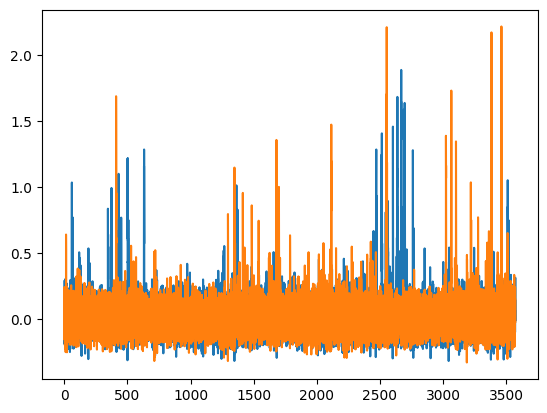

In [46]:
# Test correlation between traces
plane1, roi1, plane2, roi2 = 2, 69, 3, 88
traces1, timestamps1 = sess.get_traces(plane=plane1, roi=roi1, trace_type="dff")
traces2, timestamps2 = sess.get_traces(plane=plane2, roi=roi2, trace_type="dff")

plt.plot(timestamps1, traces1)
plt.plot(timestamps2, traces2)

# scipy.stats.linregress(traces1, traces2)
np.corrcoef(traces1, traces2)


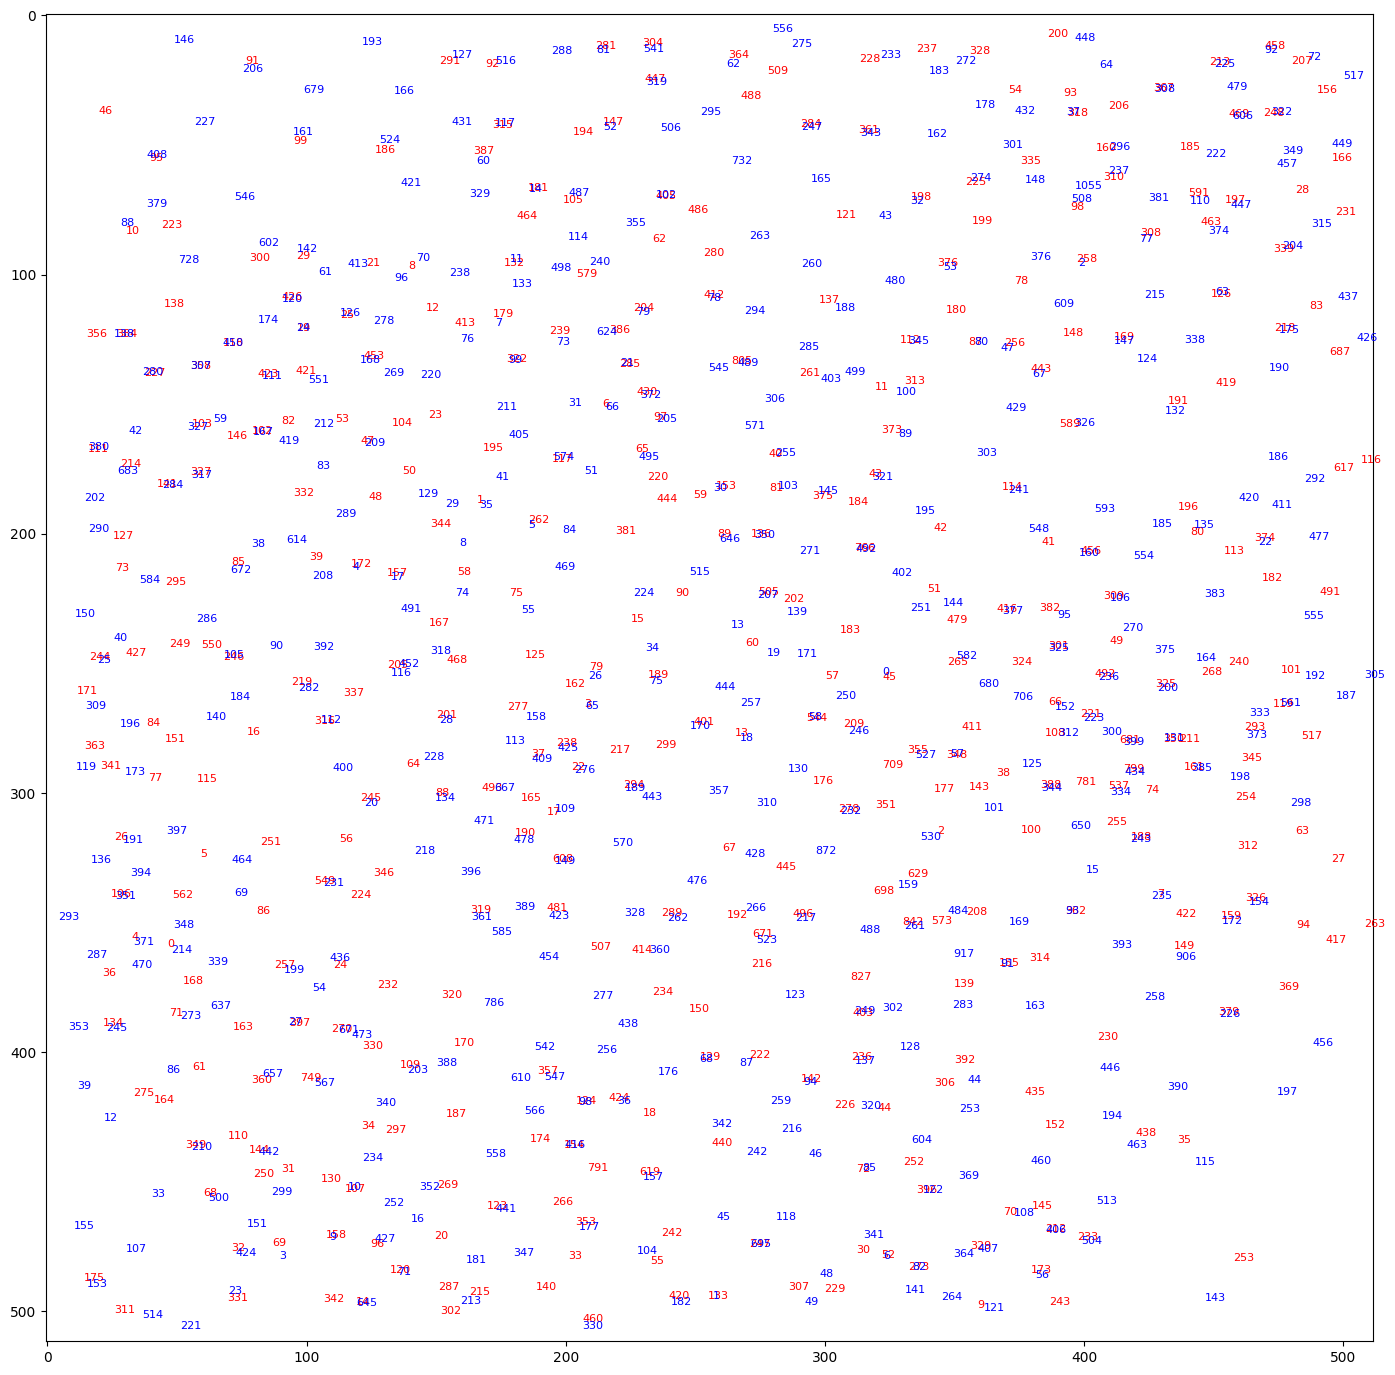

In [37]:
fig, ax = plt.subplots(figsize=(14, 14))

for plane, color in ((1, "red"), (2, "blue")):
# for plane, color in ((1, "red"), ):
    for roi in sess.get_rois(plane):
        if sess.is_roi_valid(plane, roi):
            mask = sess.get_roi_image_mask(plane, roi)
            centroid = np.mean(np.where(mask), axis=1)
            ax.text(*centroid, f"{roi}", fontsize=8, color=color)

ax.imshow(mask * 0, interpolation="nearest", cmap="gray_r")
fig.tight_layout()

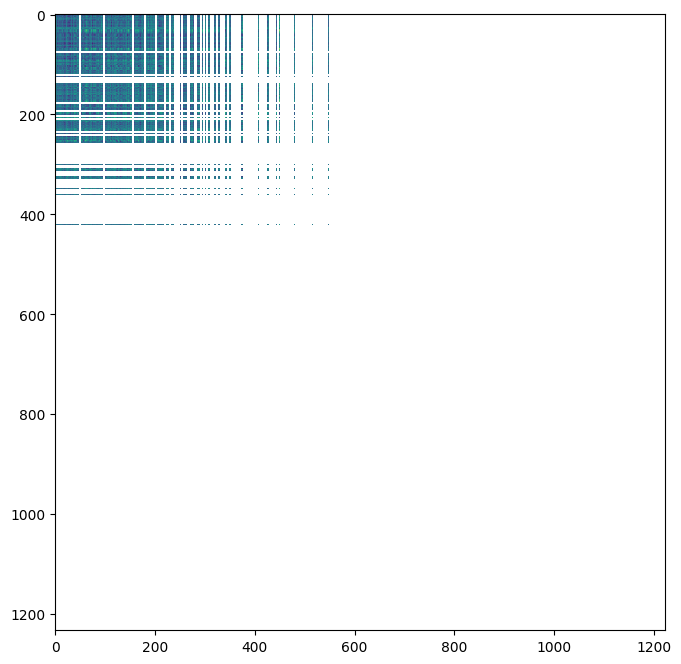

In [15]:
roi_pos_1 = np.empty((len(sess.get_rois(1)), 2))
roi_pos_2 = np.empty((len(sess.get_rois(2)), 2))

for (plane, pos_arr) in ((1, roi_pos_1), (2, roi_pos_2)):
    for roi in sess.get_rois(plane):
        if sess.is_roi_valid(plane, roi):
            mask = sess.get_roi_image_mask(plane, roi)
            pos_arr[roi, :] = np.mean(np.where(mask), axis=1)
        else:
            pos_arr[roi, :] = np.nan

centroid_distances = np.linalg.norm(roi_pos_1[:, np.newaxis, :] - roi_pos_2[np.newaxis, :, :], axis=2)

plt.figure(figsize=(8, 8))
plt.imshow(centroid_distances)

In [ ]:
from stimulus_analysis.drifting_gratings import DriftingGratings

dg1 = DriftingGratings(sess, 1, dg_type="full")
dg2 = DriftingGratings(sess, 2, dg_type="full")

# Load metrics
for dg in (dg1, dg2):
    # Make it load faster
    dg.n_chisq_shuffles = 10
    dg.n_null_distribution_boot = 100
    dg.metrics

447 319


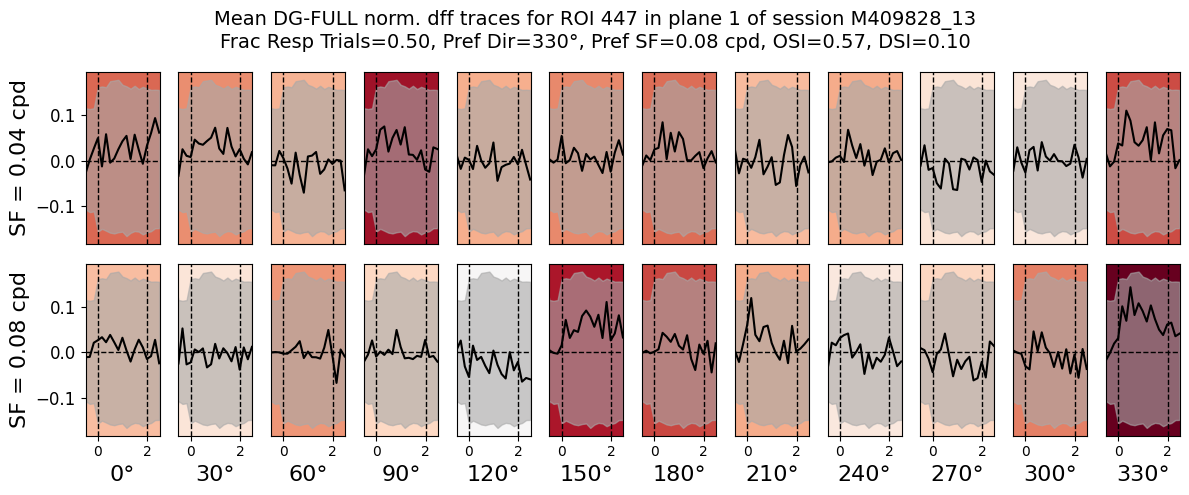

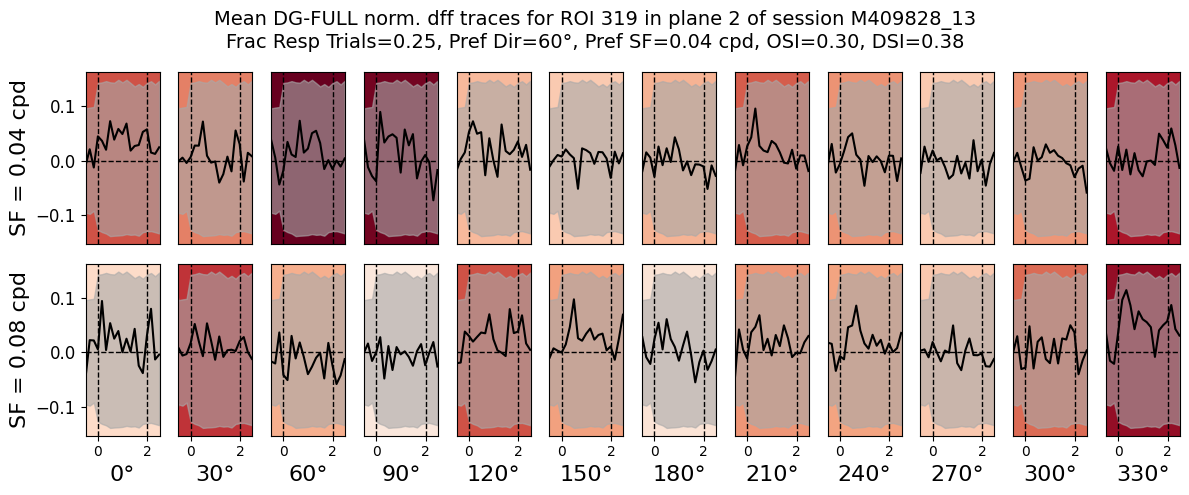

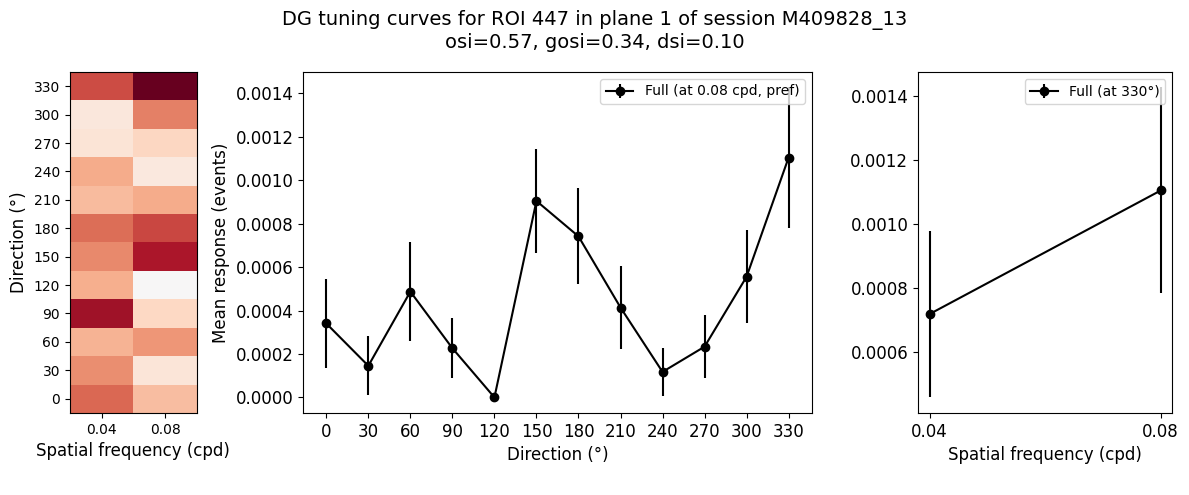

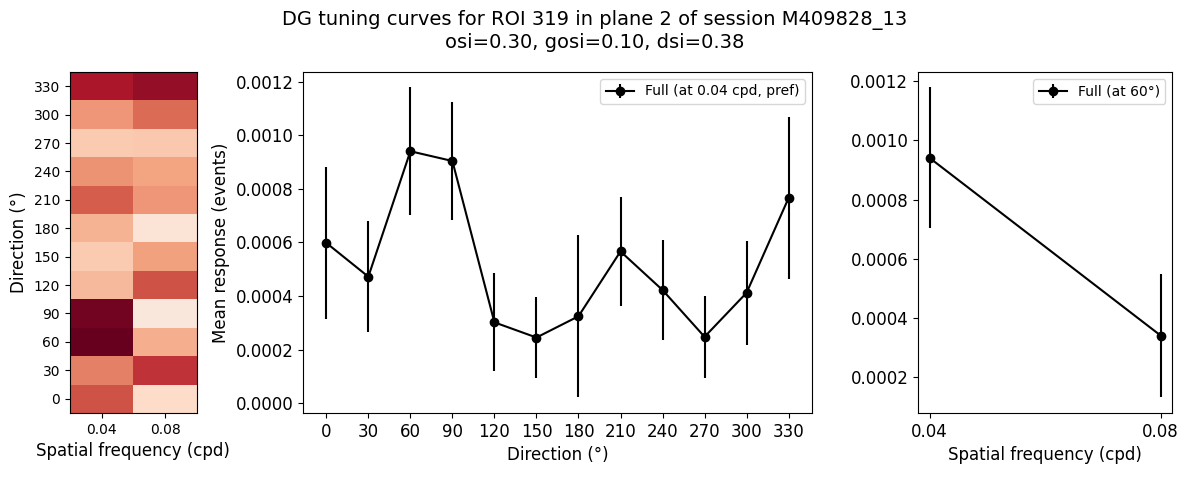

In [68]:
# Potential duplicate ROIs
# roi1, roi2 = 384, 138 # very likely duplicates
# roi1, roi2 = 469, 606
roi1, roi2 = 447, 319

print(roi1, roi2)

# Plot ROI image mask
# fig, axs = plt.subplots(figsize=(8, 4), ncols=2)
# axs[0].imshow(sess.get_roi_image_mask(1, roi1), interpolation="nearest", cmap="gray_r")
# axs[1].imshow(sess.get_roi_image_mask(2, roi2), interpolation="nearest", cmap="gray_r")

# Plot traces
# trace1, ts1 = sess.get_traces(1, roi=roi1, trace_type="events")
# trace2, ts2 = sess.get_traces(2, roi=roi2, trace_type="events")
# fig, axs = plt.subplots(figsize=(12, 4), nrows=2)
# axs[0].plot(ts1, trace1)
# axs[1].plot(ts2, trace2)
# plt.setp(axs, xlim=(500, 2000))

# Plot DGF tuning metrics
dg1.plot_roi_stim_conditions(roi1)
dg2.plot_roi_stim_conditions(roi2)
dg1.plot_roi_tuning_curves(roi1)
dg2.plot_roi_tuning_curves(roi2)

fig.tight_layout()

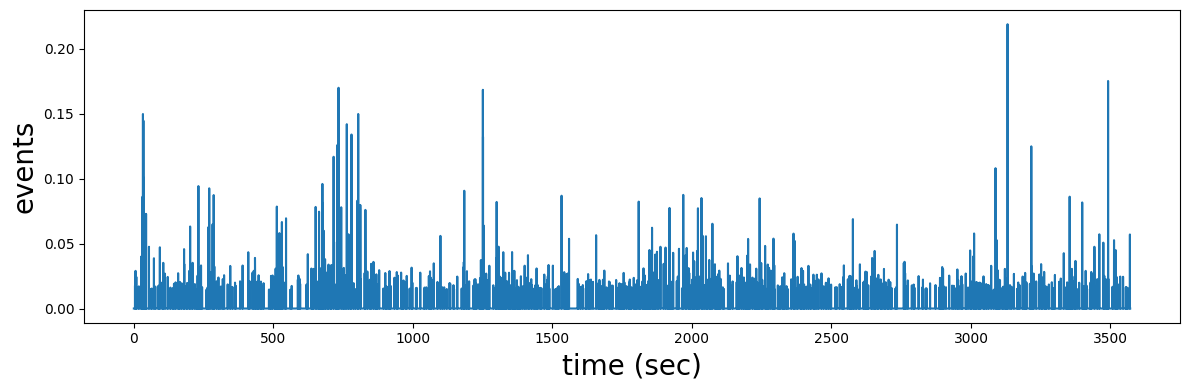

In [25]:
events, ts = sess.get_traces(plane, roi=roi, trace_type="events")

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ts, events)
ax.set_xlabel('time (sec)', fontsize=20)
ax.set_ylabel('events', fontsize=20)
fig.tight_layout()